# Homework 4

The following code shows which packages are used.

In [103]:
library(stringr)
library(dplyr)
library(tidyr)
library(zoo)
library(tidyverse)
library(DBI)
library(RSQLite)
library(tidyr)
library(ggplot2)

## Joining Data

For this exercise, we will begin by cleaning the data as we have done in previous exercise. We handle character strings and missing values and so on. To combine the cell phone data with the population data, we need to reshape both datasets. This is done by pivotting the tables into the right format. We will show a table similar to the one provided in the exercise with these columns: "iso-3", "year", "n_cellphones" and "population". We the combine the cell phone, population and country data into a single table. We calculate the number of phones per capita as "n_cellphones"/"population_size" and provide a new table with these columns: "year",	"Macao", "Hong Kong", "United Arab Emirates", "Antigua and Barbuda" and "Seychelles". A plot is then provided to analyse the country with highest growth rate of cell phones (per capita) in the last 10 years.

In [182]:
population_df <- read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
country_df <- read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")
cellphone_df <- read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")


New names:
• `` -> `...1`
Rows: 266 Columns: 63
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): iso-3
dbl (62): ...1, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 249 Columns: 11
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (7): name, alpha-2, alpha-3, iso_3166-2, region, sub-region, intermediat...
dbl (4): country-code, region-code, sub-region-code, intermediate-region-code

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 214 Columns: 57
── Column specification ────────────────────────────────────────────────

In [183]:
library(tidyverse)

# Function to convert 'k', 'M', 'B' to numeric values
k_to_expf <- function(x) {
  parse_number(str_replace_all(x, c(k = "e+03", M = "e+06", B = "e+09")))
}

# Function to replace NA with NaN
rplc_na_nan <- function(x) {
  replace_na(x, NaN)
}

# Clean and transform the cellphone data
cellphone_df <- cellphone_df %>%
  group_by(`iso-3`) %>%
  mutate(across(where(is.character), k_to_expf)) %>%
  mutate(across(where(is.logical), as.numeric)) %>%
  mutate(across(2:17, ~ replace_na(.x, 0))) %>%
  mutate(across(where(is.numeric), rplc_na_nan)) %>%
  pivot_longer(cols = !`iso-3`, names_to = "year", values_to = "n_cellphones") %>%
  fill(n_cellphones, .direction = "updown")  # Fill missing values both up and down


population_df<-population_df%>%pivot_longer(cols = !`iso-3`,names_to = "year",values_to = "population")%>%
fill(population,.direction = "updown")


cell_pop_df<-cellphone_df%>%
left_join(population_df)%>%
mutate(year=as.integer(year))%>%
arrange(year)

head(cell_pop_df)

Joining with `by = join_by(`iso-3`, year)`


iso-3,year,n_cellphones,population
<chr>,<int>,<dbl>,<dbl>
ABW,1960,0,54608
AFG,1960,0,8622466
AGO,1960,0,5357195
ALB,1960,0,1608800
AND,1960,0,9443
ARE,1960,0,133426


In [184]:
cell_pop_df<-cell_pop_df%>%
left_join(country_df%>%
          select(`alpha-3`,name)%>%
          rename(`iso-3`=`alpha-3`) )%>%
ungroup()%>%
select(name,year,n_cellphones,population)%>%
mutate(phones_per_capita=n_cellphones/population)%>%
arrange(phones_per_capita)

Joining with `by = join_by(`iso-3`)`


In [187]:
country_p_cap<-cell_pop_df%>%
select(year,phones_per_capita,name)%>%
pivot_wider(names_from=name,values_from = phones_per_capita)

candidate_countries<-country_p_cap%>%pivot_longer(cols=!year,values_to="per_cap",names_to = "Country")%>%
filter(year==2019)%>%filter(min_rank(desc(per_cap)) <= 5)

country_p_cap%>%select(year,as.character(candidate_countries$Country))%>%filter((year>=2015) & (year <=2019) )

year,United Arab Emirates,Antigua and Barbuda,Hong Kong,Macao,Seychelles
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2015,2.007424,1.956838,2.290401,3.088231,1.584260
2016,2.212521,1.987545,2.398931,3.143510,1.605459
2017,2.183431,2.019337,2.488773,3.210102,1.742433
2018,2.199084,2.008164,2.670209,3.348741,1.849900
2019,2.127739,1.997460,2.863650,3.284849,1.987196


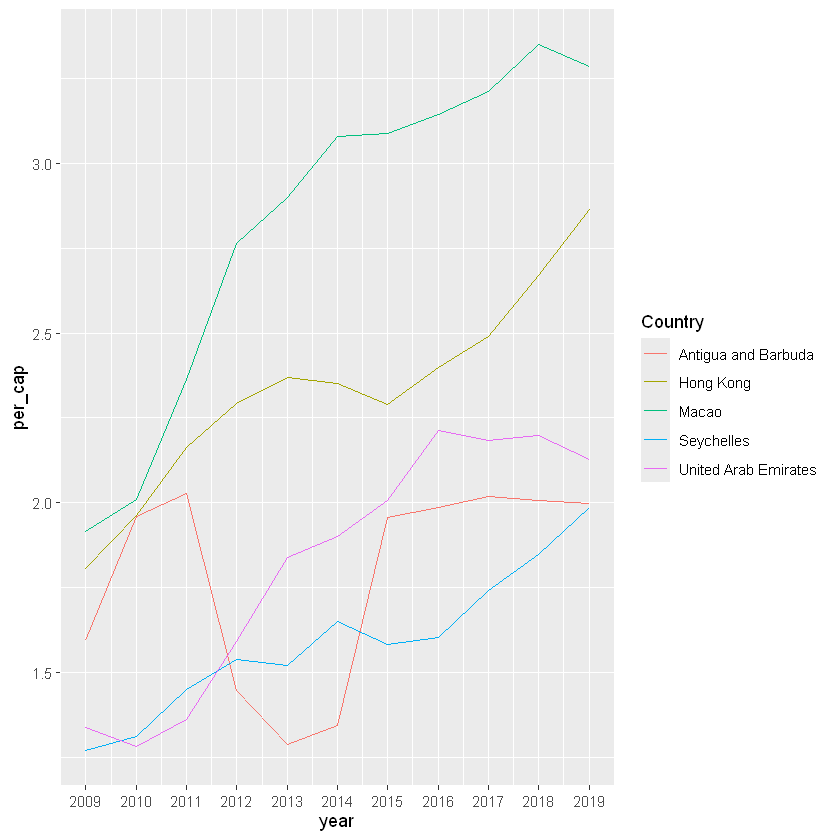

In [186]:
plot_df<-cntry_p_cap%>%pivot_longer(cols=!year,values_to="per_cap",names_to = "Country")%>%
filter(year>=2009,Country %in% (candidate_countries$Country))
ggplot(data=plot_df)+geom_line(mapping=aes(x=year,y=per_cap,color=Country),show.legend = TRUE)+ scale_x_continuous(breaks=seq(2009, 2019, 1))

As we can see from the plot Macao have had the highest growth rate in the last 10 years, from 2010 to 2019.

## SQL

The file user_action.db in the data repo contains an SQLite database that contains a table named user_actions. In this task we will analys the table and retrieve the usernames of all users who have performed tha "signup" action. Then we will display a table with these columns: "user_id", "username" and "log_count". Then for the final table we will display a table of the users who have both logged in and signed up on the same day. The table will contain the columns "user_id" and "username".

In [39]:
db_path <- "C:\\Users\\olivi\\Downloads\\user_actions.db"
con <- dbConnect(RSQLite::SQLite(), dbname = db_path)
tables <- dbListTables(con)


In [46]:
query <- "
  SELECT DISTINCT username 
  FROM user_actions 
  WHERE action = 'signup';
"


users_signup <- dbGetQuery(con, query)
users_signup

username
<chr>
user34
user28
user1
user24
user15
user20
user18
user25
user3


In [45]:
query <- "
  SELECT 
    user_id, 
    username, 
    COUNT(*) AS log_count
  FROM 
    user_actions
  GROUP BY 
    user_id, username 
"

log_counts <- dbGetQuery(con, query)
log_counts

user_id,username,log_count
<int>,<chr>,<int>
1,user1,104
2,user2,149
3,user3,108
4,user4,436
5,user5,192
6,user6,457
7,user7,362
8,user8,329
9,user9,118


In [59]:
query <- "
  SELECT DISTINCT
    a.user_id,
    a.username
  FROM
    user_actions AS a
  JOIN
    user_actions AS b
  ON
    a.user_id = b.user_id
    AND a.action = 'signup'
    AND b.action = 'login'
    AND DATE(a.timestamp) = DATE(b.timestamp);
"


both_actions <- dbGetQuery(con, query)
both_actions

user_id,username
<int>,<chr>
8,user8
12,user12
30,user30
7,user7
22,user22
5,user5
2,user2
32,user32


## Regex

In the file comments.txt we will find that the data repo contains lines of text, each representing a user comment. Users sometimes include tags in their comments using the format "#tag".

In [12]:
comments <- readLines("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/comments.txt")  
#Lines are stored in the 'comments' variable

In the code below we created a function that uses str_extract_all to extract all hashtags starting with # from a given comment. We named this function hashtags_extraction. 

When we called this function on the first comment, it successfully extracted the hashtags #programming and #python.

In [13]:
hashtags_extraction <- function(comment) {
  str_extract_all(comment, "#\\w+")[[1]]  
    #Extract all hashtags starting with "#"
}

first_comment_hashtag <- hashtags_extraction(comments[1])
#Extracting hashtags from the first comment in the file 

first_comment_hashtag

[1] "#programming" "#tips"

The following code defines a regular expression regex_python_programming that checks if both the hashtags #programming and #python appear in a comment, regardless of their order. The code also uses str_detect to check if the second comment contains both hashtags. Based on the result, it prints a message indicating whether or not both #programming and #python are mentioned in the comment.

For comment number 2, the output shows that it does not contain both hashtags.

In [20]:
regex_python_programming <- "#programming.*#python|#python.*#programming"
#The '|' operator is used for the or condition, wheter #programming or #python comes first does not matter
#The '.*' allows any characters (or none) between the two hashtags

matches <- str_detect(comments[2], regex_python_programming)
#Check if it contains both hashtags in the second comment

if (matches) {
  print("Both #programming and #python are mentioned in the comment.")
} else {
  print("The comment does not mention both #programming and #python.")
}
#A proper message is printed depending on if both #programming' and #python are found

[1] "The comment does not mention both #programming and #python."
